In [1]:
import importlib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.image import imread

%matplotlib inline

import cmocean
from glob import glob
import os

from datetime import timedelta, datetime
from datetime import timedelta as delta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pop_tools

import util
import time
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import curve_fit

import PyCO2SYS as pyco2
from PyCO2SYS import CO2SYS
import co2calc

# Fig. S1
Maximum OAE efficiency locally

## Load the GLODAP dataset 

[GLODAP](https://www.glodap.info/) is a observational synthesis of biogeochemical variables over the global ocean. <br>
Download GLODAPv2.2016b_MappedClimatologies here: https://glodap.info/index.php/mapped-data-product/

In [23]:
ds = xr.open_mfdataset('./data/GLODAP_dataset/GLODAPv2.2016b.*.nc', compat='override')
# subset for surface
ds = ds.isel(depth_surface=0, drop=True)

ds = ds.rename({
    'TCO2': 'DIC',
    'TAlk': 'ALK',
    'salinity': 'SALT',
    'silicate': 'SiO3',
    'temperature': 'TEMP',
    
})

Use pyco2sys

In [24]:
# Grab data and slice out just the surface layer
glodap_tco2 = ds.DIC
glodap_talk = ds.ALK
glodap_salinity = ds.SALT
glodap_theta = ds.TEMP
glodap_phosphate = ds.PO4
glodap_silicate = ds.SiO3

In [25]:
# For DIC/Alk only include areas where there's data for both.
gd_tco2      = np.where( (glodap_tco2>0) & (glodap_talk>0), glodap_tco2, np.nan)
gd_talk      = np.where( (glodap_tco2>0) & (glodap_talk>0), glodap_talk, np.nan)
gd_salinity  = np.where(glodap_salinity>0, glodap_salinity, np.nan)
gd_theta     = np.where(glodap_theta>-30, glodap_theta, np.nan)
gd_phosphate = np.where(glodap_phosphate>0, glodap_phosphate, np.nan)
gd_silicate  = np.where(glodap_silicate>0, glodap_silicate, np.nan)

In [26]:
def calcCO2SYS(alk,    # (in umol/kg)
               dic,    # (in umol/kg)
               sal      =   35,  # Salinity of the sample
               temp     =   10,  # Temperature at input conditions
               sil      =   0.5,  # Concentration of silicate  in the sample (in umol/kg)
               po4      =    2,  # Concentration of phosphate in the sample (in umol/kg)
               pres     =    0,  # Pressure    at input conditions
               pHscale  =    1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
               k1k2c    =    4,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
               kso4c    =    1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson"
  ):
  delta = 0.1 # µmol/L or mmol/m^3
  csys = CO2SYS(alk,dic,1,2,sal,temp,temp,pres,pres,sil,po4, pHscale, k1k2c, kso4c)
  csys_dic = CO2SYS(alk,dic+delta,1,2,sal,temp,temp,pres,pres,sil,po4, pHscale, k1k2c, kso4c)
  csys_alk = CO2SYS(alk+delta,dic,1,2,sal,temp,temp,pres,pres,sil,po4, pHscale, k1k2c, kso4c)

  dpCO2dDIC = (csys_dic['pCO2in'] - csys['pCO2in'])/delta
  dpCO2dAlk = (csys_alk['pCO2in'] - csys['pCO2in'])/delta
  dCO2dDIC = (csys_dic['CO2out'] - csys['CO2out'])/delta
  dCO2dAlk = (csys_alk['CO2out'] - csys['CO2out'])/delta
  eta_co2 = -dpCO2dAlk/dpCO2dDIC
  csys["dpCO2dDIC"] = dpCO2dDIC
  csys["dpCO2dAlk"] = dpCO2dAlk
  csys["dCO2dDIC"] = dCO2dDIC
  csys["dCO2dAlk"] = dCO2dAlk
  csys["eta_co2"] = eta_co2
  csys["dDICdAlk"] = eta_co2

  if(type(alk)==np.ndarray):
    for k in csys.keys():
      csys[k] = np.reshape(csys[k], newshape=alk.shape)

  return csys


csys_glodap = calcCO2SYS(alk=gd_talk,
                  dic=gd_tco2,
                  sal=gd_salinity,
                  temp=gd_theta,
                  sil=gd_silicate,
                  po4=gd_phosphate,
                  pres=0,
                  pHscale=1, k1k2c=4, kso4c=1)

dDICdAlk_approx = 1/(3-2*gd_tco2/gd_talk)

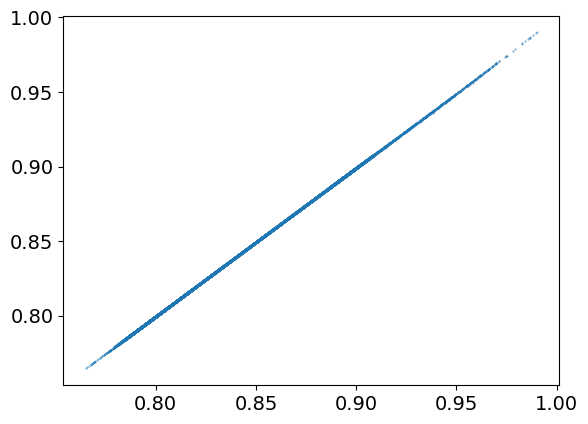

In [27]:
plt.scatter(1/csys_glodap["isoQout"], csys_glodap["dDICdAlk"], s=0.1)

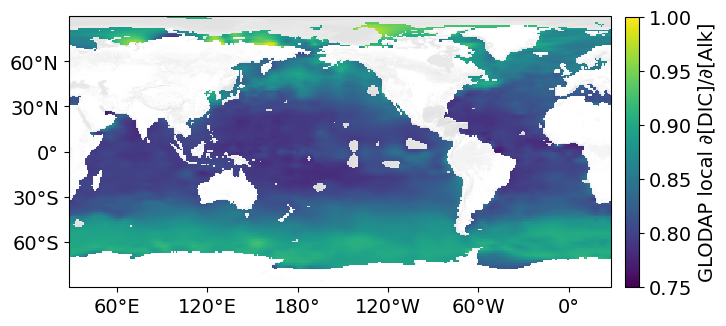

In [33]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=208))
sc = ax.pcolormesh(glodap_tco2.lon, glodap_tco2.lat, 1/csys_glodap["isoQout"], transform=ccrs.PlateCarree(), \
                        cmap='viridis', 
                        vmin=0.75, vmax=1
                        )
# Create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.27, 0.02, 0.45])  # x,y, width, height


cmap = cm.get_cmap('viridis')  # Choose a colormap
normalize = plt.Normalize(vmin=0.75, vmax=1)  # Normalize the color values
sm = cm.ScalarMappable(cmap=cmap, norm=normalize)

cbar = fig.colorbar(sm, cax=cax, shrink=0.5, label='Max OAE efficiency')
cbar.ax.tick_params()
cbar.ax.set_ylabel('GLODAP local ∂[DIC]/∂[Alk]')

ax.set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
#ax.add_feature(cfeature.LAND)

ax.set_yticks(np.arange(-60, 90, 30), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree());
ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

plt.savefig('./figures/Figure_S1.png', dpi=200, bbox_inches='tight')
plt.savefig('./figures/Figure_S1.pdf', bbox_inches='tight')

# Fig. S2
Maps of OAE efficiency

In [29]:
eff_all_eff = xr.open_dataset('./data/Map_oae_eff_5x4.nc')

In [30]:
eff_all_eff

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 321, season: 4, year: 15)
Coordinates:
  * season   (season) object 'January' 'April' 'July' 'October'
  * year     (year) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    eff      (season, year, nlat, nlon) float64 ...

CPU times: user 3min 59s, sys: 3.38 s, total: 4min 3s
Wall time: 4min 4s


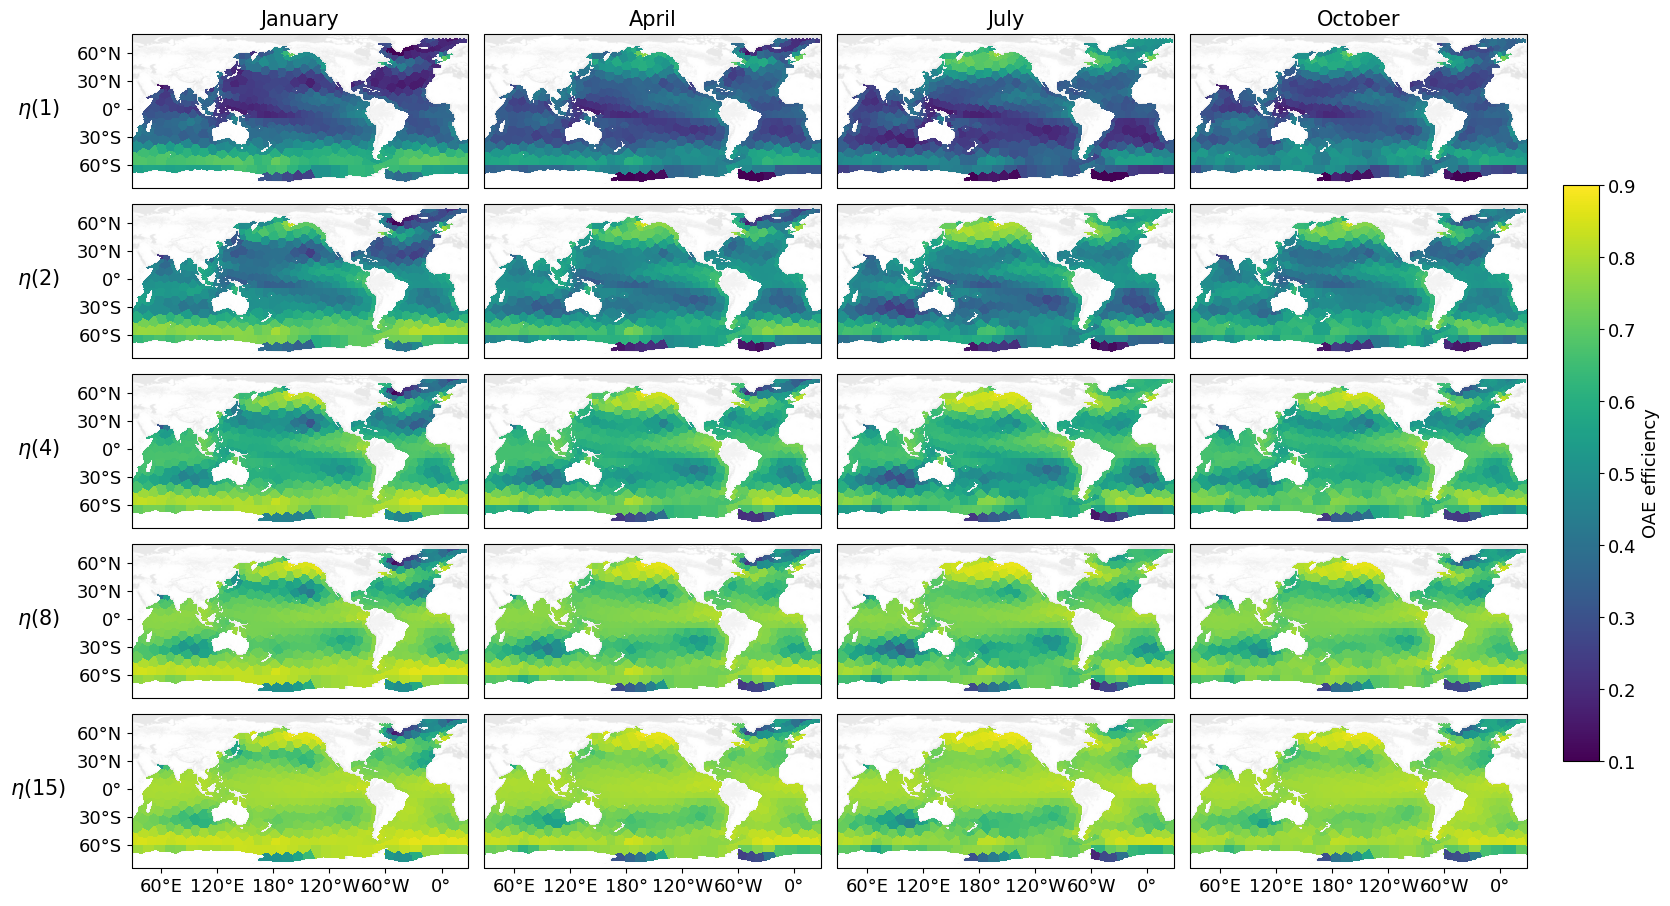

In [32]:
%%time
from matplotlib import cm
FONTSIZE = 13

def modify(ax):
    ax.set_extent([0, 360, -85, 80], crs=ccrs.PlateCarree())
    
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  
    ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
    #ax.stock_img()

years = [1,2,4,8,15]

fig = plt.figure(figsize=(18,11))
for i in range(5):
    for j in range(4):
        ax = fig.add_subplot(5, 4, i*4+j+1, projection=ccrs.PlateCarree(central_longitude=208))

        ax.pcolormesh(eff_all_eff.TLONG, eff_all_eff.TLAT, eff_all_eff.isel(season=j, year=years[i]-1).eff, transform=ccrs.PlateCarree(), \
                         cmap='viridis', 
                        vmin=0.1, vmax=0.9
                        )
        if i == 0:
            ax.set_title(f'{eff_pacific.season.values[j]}', loc='center', fontsize=FONTSIZE+2)
        if j == 0:
            ax.set_yticks(np.arange(-60, 80, 30), crs=ccrs.PlateCarree())
            ax.set_yticklabels(ax.get_yticks(), fontsize=FONTSIZE)
            ax.text(-280, 0, f'$\\eta$({eff_pacific.year.values[years[i]-1]})', rotation='horizontal', va='center', ha='center', fontsize=FONTSIZE+2)
            #ax.text(-280, 30, f'After {eff_pacific.year.values[i]} years', rotation='vertical', va='center', ha='center', fontsize=FONTSIZE+2)

        if i == 4:
            ax.set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree())
            ax.set_xticklabels(ax.get_xticks(), fontsize=FONTSIZE)

        modify(ax)

# Create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.65])  # Adjust position and size as needed
cax.set_aspect(0.5)  # Adjust width
cax.set_aspect(20)  # Adjust height

cmap = cm.get_cmap('viridis')  # Choose a colormap
normalize = plt.Normalize(vmin=0.1, vmax=0.9)  # Normalize the color values
sm = cm.ScalarMappable(cmap=cmap, norm=normalize)

cbar = fig.colorbar(sm, cax=cax, shrink=0.5, label='OAE efficiency')
cbar.ax.tick_params(labelsize=FONTSIZE)
cbar.ax.set_ylabel('OAE efficiency', fontsize=FONTSIZE)

plt.subplots_adjust(wspace=0.05, hspace=0.02)

plt.savefig('./figures/Figure_S2.png', dpi=400, bbox_inches='tight')
plt.savefig('./figures/Figure_S2.pdf', bbox_inches='tight')

# Fig. S6
Max change in omega and pH for experiments in each polygon

## Calculate the max change in omega and pH for experiments in each polygon

### Omega

This dataset is stored on NCAR's computers.

In [15]:
%%time
# unperturbed condition, i.e. without OAE
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
temp = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.TEMP.030601-036812.nc') # potential temp
salt = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.SALT.030601-036812.nc') # potential salinity
si = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.SiO3.030601-036812.nc') # SiO3
po4 = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.PO4.030601-036812.nc') # PO4

CPU times: user 106 ms, sys: 15.7 ms, total: 121 ms
Wall time: 681 ms


In [16]:
# Select the the first 2 months of model output to find the maximum change of omega
days = 2 # the amount of months calculated 
first_time_index = 492 # Jan 1999

start_indices = [first_time_index, first_time_index+3, first_time_index+6, first_time_index+9] # starting time for OAE in different seasons

L_salinity = []
L_theta = []
L_phosphate = []
L_silicate = []
for s in range(4):

    salinity = salt.SALT.isel(z_t=0, time=slice(start_indices[s], start_indices[s]+days))
    theta = temp.TEMP.isel(z_t=0, time=slice(start_indices[s], start_indices[s]+days))
    phosphate = po4.PO4.isel(z_t=0, time=slice(start_indices[s], start_indices[s]+days))
    silicate = si.SiO3.isel(z_t=0, time=slice(start_indices[s], start_indices[s]+days))
    
    L_salinity.append(salinity.values)
    L_theta.append(theta.values)
    L_phosphate.append(phosphate.values)
    L_silicate.append(silicate.values)

Solve CO2 system

In [17]:
def cal_dDICdCO2(talk, tco2, salinity, theta, phosphate, silicate):
    
    return pyco2.sys(
            par1=talk,
            par2=tco2,
            par1_type=1,
            par2_type=2,
            salinity=salinity,
            temperature=theta,
            total_phosphate=phosphate,
            total_silicate=silicate,
        )

In [18]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]
tlong = grid.TLONG.values
tlat = grid.TLAT.values

Pacific_polygon_masks = np.load('./data/polygon_data/Pacific_final_polygon_mask.npy')
Atlantic_polygon_masks = np.load('./data/polygon_data/Atlantic_final_polygon_mask.npy')
South_polygon_masks = np.load('./data/polygon_data/South_final_polygon_mask_120EEZ_180openocean.npy')
Southern_Ocean_polygon_masks = np.load('./data/polygon_data/Southern_Ocean_final_polygon_mask.npy')

regs = ['North_Atlantic_basin', 'North_Pacific_basin', 'South', 'Southern_Ocean']
num_polys = [150, 200, 300, 40]
all_region_masks = [Atlantic_polygon_masks, Pacific_polygon_masks, South_polygon_masks, Southern_Ocean_polygon_masks]
seasons = ['01', '04', '07', '10']
seasons_num = [1,4,7,10]
start_indices = [first_time_index, first_time_index+3, first_time_index+6, first_time_index+9]

In [19]:
def cal_max_omega_change(da, s, days=2):

    '''
    s: season index
    da: has only 2 time steps here
    '''

    tco2 = da.isel(z_t=0).DIC
    talk = da.isel(z_t=0).ALK
    
    tco2_ctrl = da.isel(z_t=0).DIC_ALT_CO2
    talk_ctrl = da.isel(z_t=0).ALK_ALT_CO2
    
    csys = cal_dDICdCO2(talk.values, tco2.values, L_salinity[s], L_theta[s], L_phosphate[s], L_silicate[s])
    csys_ctrl = cal_dDICdCO2(talk_ctrl.values, tco2_ctrl.values, L_salinity[s], L_theta[s], L_phosphate[s], L_silicate[s])

    max_D_omega = np.nanmax(csys['saturation_aragonite'] - csys_ctrl['saturation_aragonite'])

    return max_D_omega

In [20]:
def get_map_omega_change():
    
    '''
    Generate maps of max omega change in each polygon.
    '''

    x,y = tlong.shape
    whole_eff = np.zeros((4, x, y)) # store 4 seasons of map view


    for r, n, masks in zip(regs, num_polys, all_region_masks):

        for p in range(n):  # number of polygons
            mask = masks[p]
            index = np.where(mask > 0)

            for s in range(4):  # 4 seasons

                
                fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/'
                case1 = fpath + f'smyle-fosi.{r}.alk-forcing-{r}.{p:03d}-1999-{seasons[s]}/ocn/hist/smyle-fosi.{r}.alk-forcing-{r}.{p:03d}-1999-{seasons[s]}.pop.h.0347-{seasons_num[s]:02d}.nc'
                case2 = fpath + f'smyle-fosi.{r}.alk-forcing-{r}.{p:03d}-1999-{seasons[s]}/ocn/hist/smyle-fosi.{r}.alk-forcing-{r}.{p:03d}-1999-{seasons[s]}.pop.h.0347-{(seasons_num[s]+1):02d}.nc'
                da = xr.open_mfdataset([case1, case2])
                
                value = cal_max_omega_change(da, s, days=2)

                print(r, p, s, value)
                
                eff = mask * value
                whole_eff[s,:,:][index] = eff[index]

    whole_eff = np.where(whole_eff == 0, np.nan, whole_eff)  
    
    # form a dataset
    whole_eff_ds = xr.Dataset(

        data_vars = {
            'max_omega_change': (["season", "nlat", "nlon"], whole_eff),
        },
        coords=dict(
            season = (["season"], ['Januaray', 'April', 'July', 'October']),
            TLONG=(["nlat", "nlon"], tlong),
            TLAT=(["nlat", "nlon"], tlat),
        ),
    )
    
    
    return whole_eff_ds

In [25]:
%%time
whole_ds = get_map_omega_change()    
whole_ds.to_netcdf(f'./get_map_omega_change.nc')

North_Atlantic_basin 0 0 0.03471720628295283
North_Atlantic_basin 0 1 0.04775807668084742
North_Atlantic_basin 0 2 0.16114454210699813
North_Atlantic_basin 0 3 0.06165773531737839
North_Atlantic_basin 1 0 0.10671262495728051
North_Atlantic_basin 1 1 0.11431590875714726
North_Atlantic_basin 1 2 0.15668256548292536
North_Atlantic_basin 1 3 0.13759595975221828
North_Atlantic_basin 2 0 0.11502396427815942
North_Atlantic_basin 2 1 0.17095709329818476
North_Atlantic_basin 2 2 0.2409127731313263
North_Atlantic_basin 2 3 0.14264200149719386
North_Atlantic_basin 3 0 0.09023268086979375
North_Atlantic_basin 3 1 0.15629504255702065
North_Atlantic_basin 3 2 0.22233331879340845
North_Atlantic_basin 3 3 0.13247313718993947
North_Atlantic_basin 4 0 0.20851737603790443
North_Atlantic_basin 4 1 0.23525538885763275
North_Atlantic_basin 4 2 0.26183772375354497
North_Atlantic_basin 4 3 0.21828451744233401
North_Atlantic_basin 5 0 0.3096900038534467
North_Atlantic_basin 5 1 0.20138643432956904
North_Atlant

### pH

In [21]:
def get_map_pH_change():
    
    '''
    Generate maps of max pH change in each polygon.
    '''

    x,y = tlong.shape
    whole_eff = np.zeros((4, x, y)) # store 4 seasons of map view

    bin_edges = combined_ds_all.dist2center.values

    for r, n, masks in zip(regs, num_polys, all_region_masks):

        for p in range(n):  # number of polygons
            mask = masks[p]

            for s in range(4):  # 4 seasons

                print(r, p, s)
                fpath = f'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/'
                case = fpath + f'smyle-fosi.{r}.alk-forcing-{r}.{p:03d}-1999-{seasons[s]}/ocn/hist/smyle-fosi.{r}.alk-forcing-{r}.{p:03d}-1999-{seasons[s]}.pop.h.0347-*.nc'
                da = xr.open_mfdataset(case)
                
                value = (da.PH - da.PH_ALT_CO2).max().values.item()
                
                eff = mask * value
                index = np.where(eff > 0)
                whole_eff[s,:,:][index] = eff[index]

    whole_eff = np.where(whole_eff == 0, np.nan, whole_eff)  
    
    # form a dataset
    whole_eff_ds = xr.Dataset(

        data_vars = {
            'max_pH_change': (["season", "nlat", "nlon"], whole_eff),
        },
        coords=dict(
            season = (["season"], combined_ds_all.season.values),
            TLONG=(["nlat", "nlon"], tlong),
            TLAT=(["nlat", "nlon"], tlat),
        ),
    )
    
    
    return whole_eff_ds

In [28]:
%%time
whole_ds = get_map_pH_change()    
whole_ds.to_netcdf(f'./get_map_pH_change.nc')

North_Atlantic_basin 0 0
North_Atlantic_basin 0 1
North_Atlantic_basin 0 2
North_Atlantic_basin 0 3
North_Atlantic_basin 1 0
North_Atlantic_basin 1 1
North_Atlantic_basin 1 2
North_Atlantic_basin 1 3
North_Atlantic_basin 2 0
North_Atlantic_basin 2 1
North_Atlantic_basin 2 2
North_Atlantic_basin 2 3
North_Atlantic_basin 3 0
North_Atlantic_basin 3 1
North_Atlantic_basin 3 2
North_Atlantic_basin 3 3
North_Atlantic_basin 4 0
North_Atlantic_basin 4 1
North_Atlantic_basin 4 2
North_Atlantic_basin 4 3
North_Atlantic_basin 5 0
North_Atlantic_basin 5 1
North_Atlantic_basin 5 2
North_Atlantic_basin 5 3
North_Atlantic_basin 6 0
North_Atlantic_basin 6 1
North_Atlantic_basin 6 2
North_Atlantic_basin 6 3
North_Atlantic_basin 7 0
North_Atlantic_basin 7 1
North_Atlantic_basin 7 2
North_Atlantic_basin 7 3
North_Atlantic_basin 8 0
North_Atlantic_basin 8 1
North_Atlantic_basin 8 2
North_Atlantic_basin 8 3
North_Atlantic_basin 9 0
North_Atlantic_basin 9 1
North_Atlantic_basin 9 2
North_Atlantic_basin 9 3


## Plot Figure S6

In [36]:
# Permutter runs
whole_ds_ph = xr.open_dataset('./data/Map_max_pH_change.nc')
whole_ds_omega = xr.open_dataset('./data/Map_max_omega_change.nc')

In [38]:
max_over_season = whole_ds_ph.max(dim='season')
max_over_season_omega = whole_ds_omega.max(dim='season')

max_over_season = util.pop_add_cyclic(max_over_season)
max_over_season_omega = util.pop_add_cyclic(max_over_season_omega)

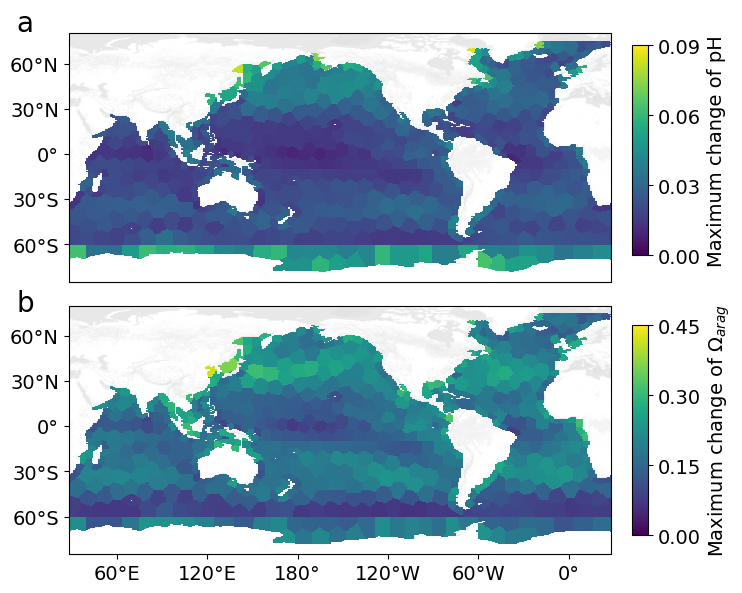

In [39]:
FONTSIZE = 14
def modify(ax):
    ax.set_extent([0, 360, -85, 80], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 
    ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
    #ax.stock_img()
    # ax.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
    # ax.set_yticklabels(ax.get_yticks(), fontsize=FONTSIZE)

central_longitude=208

labels = ['a', 'b']

fig = plt.figure(figsize=(7,7))


ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=central_longitude))
ax1 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=central_longitude))
ax.pcolormesh(max_over_season.TLONG, max_over_season.TLAT, max_over_season.max_pH_change,
              transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.09)
ax1.pcolormesh(max_over_season_omega.TLONG, max_over_season_omega.TLAT, max_over_season_omega.max_omega_change,
              transform=ccrs.PlateCarree(), cmap='viridis', vmin=0, vmax=0.45)

ax.text(0.05, 0.87, labels[0], transform=fig.transFigure, fontsize=FONTSIZE+6)
ax1.text(0.05, 0.47, labels[1], transform=fig.transFigure, fontsize=FONTSIZE+6)


ax.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
ax.set_yticklabels(ax.get_yticks(), fontsize=FONTSIZE)
ax1.set_xticks(np.arange(0, 360, 60), crs=ccrs.PlateCarree())
ax1.set_xticklabels(ax1.get_xticks(), fontsize=FONTSIZE)

ax1.set_yticks([-60,-30,0,30,60], crs=ccrs.PlateCarree())
ax1.set_yticklabels(ax1.get_yticks(), fontsize=FONTSIZE)
    
modify(ax)
modify(ax1)

def add_colorbar(x0, y0, vmin, vmax, label, num_levels_ticks, cmap_label='viridis'):
    '''
    x0, y0: start location for the colorbar
    vmin, vmax: range of the colorbar
    label: label of the colorbar'
    '''
    cax = fig.add_axes([x0, y0, 0.023, 0.3])  # [x0, y0, width, height]
    cmap = plt.colormaps[cmap_label]
    normalize = plt.Normalize(vmin=vmin, vmax=vmax)  # Normalize the color values
    sm = cm.ScalarMappable(cmap=cmap, norm=normalize)
    cbar = fig.colorbar(sm, cax=cax, shrink=0.9, label=label, orientation='vertical', ticks=np.linspace(vmin, vmax, num_levels_ticks))
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.ax.xaxis.label.set_size(FONTSIZE+3)

add_colorbar(0.93, 0.55, 0, 0.09, 'Maximum change of pH', 4)
add_colorbar(0.93, 0.15, 0, 0.45, 'Maximum change of $\u03A9_{arag}$', 4)
plt.subplots_adjust(wspace=0.05, hspace=0.02)

plt.savefig('./figures/Figure_S6.png', dpi=300, bbox_inches='tight')
plt.savefig('./figures/Figure_S6.pdf', bbox_inches='tight')